In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 37.6 MB/s eta 0:00:00


In [22]:
import torch
from torch.utils.data import DataLoader
import tqdm
from datasets import load_dataset
from torchvision.models import resnet50
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import pickle
from sklearn.metrics import accuracy_score
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [5]:

dataset = load_dataset("Maysee/tiny-imagenet")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:

train = dataset["train"]
val = dataset["valid"]

In [20]:
class TinyImageNetDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image = self.dataset[index]["image"]
        label = self.dataset[index]["label"]

        if self.transform:
            image = self.transform(image)
        # if grayscale, convert to 3-channel
        if image.size(0) == 1:
            image = image.repeat(3, 1, 1)

        if self.transform:
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            
        label = torch.tensor(label)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [8]:

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
   
])

In [23]:
train_dataset = TinyImageNetDataset(train, transform)
val_dataset = TinyImageNetDataset(val, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [10]:
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9

In [21]:
class Resnet50TinyImageNet(nn.Module):
  # load the pretrained ResNet50 model
  # freeze the weights of the pre-trained layers
  # modify the last layer to output 200 classes
    def __init__(self):
        super(Resnet50TinyImageNet, self).__init__()
        self.model = resnet50()
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 200)
    
    def forward(self, x):
        return self.model(x)
    
    def train(self, train_loader, criterion, optimizer, num_epochs=10):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        
        for epoch in range(num_epochs):
            train_loss = 0.0
            train_acc = 0.0
            
            self.model.train()
            for image, label in tqdm.tqdm(train_loader):
                image = image.to(device)
                label = label.to(device)
                
                optimizer.zero_grad()
                
                outputs = self.model(image)
                loss = criterion(outputs, label)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * image.size(0)
                _, prediction = torch.max(outputs, 1)
                train_acc += torch.sum(prediction == label.data)
            
            train_loss = train_loss / len(train_loader.dataset)
            train_acc = train_acc / len(train_loader.dataset)

            self.model.eval()
            val_acc = 0.0

            for image,label in val_loader:
              image = image.to(device)
              labal = label.to(device)
              outputs = self.model(image)
              _, prediction = torch.max(outputs,1)
              val_acc += torch.sum(prediction == label.data)

            val_acc = val_acc/len(val_loader.dataset)




            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}\tValidation Accuracy: {:.6f}'.format(
                epoch+1, train_loss, train_acc,val_acc))
            

    def test(self, test_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.model.eval()
        predictions = []
        # true = []

        for image, label in tqdm.tqdm(test_loader):
            image = image.to(device)
            label = label.to(device)

            outputs = self.model(image)
            _, prediction = torch.max(outputs, 1)
            predictions.append(prediction)
            # true.append(label.data)

        predictions = torch.cat(predictions, dim=0)
        true = torch.cat(true, dim=0)

        print("Accuracy: ", accuracy_score(true.cpu(), predictions.cpu()))

        return predictions


In [12]:
torch.cuda.is_available()

True

In [ ]:
model = Resnet50TinyImageNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)



In [13]:


model = Resnet50TinyImageNet()

# setting to model to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(r'/content/drive/MyDrive/SMAI/res3.pth', map_location=device))

model

Resnet50TinyImageNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [14]:
pred = model.test(val_loader)

100%|██████████| 157/157 [00:33<00:00,  4.63it/s]

Accuracy:  0.2615


In [ ]:
acc = 0
correct_preds = []
for i in range(10000):
  out = model(val_dataset[i][0].unsqueeze(0).to(device))
  out = F.softmax(out)

  _, pred = torch.max(out, 1)
  
  #compare pred with val_dataset[i][1]
  if pred == val_dataset[i][1]:
      correct_preds.append(i)
      acc += 1

print(acc/10000)


In [ ]:
print(correct_preds)
print(len(correct_preds))

In [38]:
def SIMBA_single_unt(x,y,model,epsilon=0.2,num_iters = 10000):
  n_dims = x.view(1,-1).size(1)
  perm = torch.randperm(n_dims)
  x = x.unsqueeze(0)
  x_probs = F.softmax(model(x))
  def_prob = x_probs[0][y]


  for i in range(num_iters):
    delta = torch.zeros(n_dims).to(device)
    delta[perm[i]] = epsilon
    add_vec = x + delta.view(x.size())
    # new_prob = F.softmax(model(add_vec))[0][y]
    probs = F.softmax(model(add_vec))
    new_probs = probs[0][y]
    ad_prob, ad_pred = torch.max(ad_out, 1)

    if ad_probs > new_probs:
      break

    if new_prob < def_prob:
      x = add_vec
      def_prob = new_prob
    else:
      x = x - delta.view(x.size())
      def_prob = F.softmax(model(add_vec))[0][y]
  
  return x.squeeze(), i, ad_pred

# def SIMBA_single_tar(x,y,model,epsilon=0.2,num_iters=10000):
#   # targetted adverse attack function
#   n_dims - x.view(1,-1).size(1)
#   perm = torch.randperm(n_dims)
#   x = x.unsqueeze(0)
#   x_probs = F.softmax(model(x))
#   def_prob = x_probs[0][y]

#   for i in range(num_iters):
#     delta = torch.zeros(n_dims)










In [50]:
adv_img,num_iters, ad_pred = SIMBA_single_unt(val_dataset[0][0].to(device),val_dataset[1][1].to(device),model.to(device))

<ipython-input-38-93352dd61580>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x_probs = F.softmax(model(x))
<ipython-input-38-93352dd61580>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  new_prob = F.softmax(model(add_vec))[0][y]
<ipython-input-38-93352dd61580>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  def_prob = F.softmax(model(add_vec))[0][y]


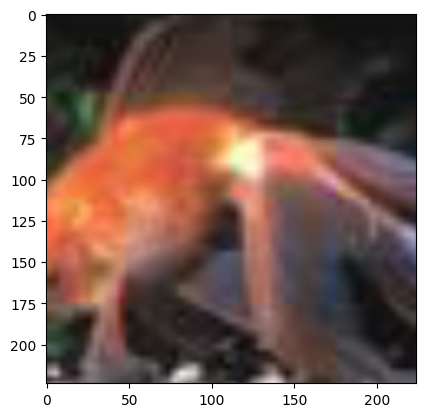

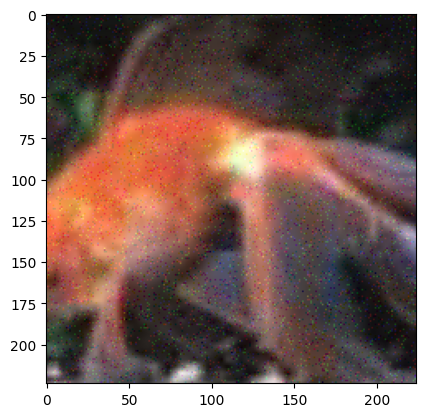

In [51]:
plt.imshow(val_dataset[0][0].permute(1,2,0))
plt.show()
plt.imshow(adv_img.cpu().permute(1,2,0))
plt.show()

In [52]:

out = model(val_dataset[0][0].unsqueeze(0).to(device))
out = F.softmax(out)

_, pred = torch.max(out, 1)

ad_out = model(adv_img.unsqueeze(0).to(device))
ad_out = F.softmax(ad_out)

_, ad_pred = torch.max(ad_out, 1)

print("Actual Class:",val_dataset[0][1])
print("Predicted Class:",pred)
print("After Attack:",ad_pred)

  


Actual Class: tensor(0)
Predicted Class: tensor([0], device='cuda:0')
After Attack: tensor([122], device='cuda:0')


<ipython-input-52-69e542409523>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)
<ipython-input-52-69e542409523>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ad_out = F.softmax(ad_out)
